# Logistic Regression and Two-Layer Neural Network

This notebook implements and compares two models for binary classification on synthetic data:
- Logistic Regression trained with Stochastic Gradient Descent (SGD)
- A Two-Layer Neural Network with one hidden layer

The code generates synthetic data, trains both models, evaluates their performance, and visualizes the results.

## Imports

Import necessary libraries for numerical computations, plotting, and geometric operations.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import math

## Activation Functions

Define the sigmoid activation function and its derivative, used in both models.

In [5]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """Compute the sigmoid activation function."""
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_derivative(sig: np.ndarray) -> np.ndarray:
    """Compute the derivative of the sigmoid function given sigmoid output."""
    return sig * (1.0 - sig)

## Logistic Regression with SGD

Implement a logistic regression model trained using stochastic gradient descent.

In [6]:
class LogisticRegressionSGD:
    """Simple logistic regression trained with stochastic gradient descent."""
    def __init__(self, lr: float = 0.12):
        self.lr = lr
        self.W: np.ndarray = None

    def fit(self,
            X_train: np.ndarray,
            y_train: np.ndarray,
            X_val: np.ndarray,
            y_val: np.ndarray,
            epochs: int = 250,
            max_repeats: int = 3,
            target_acc: float = 90.0) -> list:
        """Train until validation accuracy >= target_acc or max_repeats reached."""
        n_samples, n_features = X_train.shape
        X_train_bias = np.hstack([X_train, np.ones((n_samples, 1))])
        X_val_bias = np.hstack([X_val, np.ones((X_val.shape[0], 1))])

        cost_history = []
        for _ in range(max_repeats):
            self.W = np.random.uniform(-1, 1, size=(n_features + 1,))
            history = []
            for _ in range(epochs):
                epoch_cost = []
                for x_i, y_i in zip(X_train_bias, y_train):
                    net = self.W.dot(x_i)
                    out = sigmoid(net)
                    error = out - y_i
                    epoch_cost.append(error**2)
                    grad = error * sigmoid_derivative(out) * x_i
                    self.W -= self.lr * grad
                history.append(np.mean(epoch_cost))

            val_out = sigmoid(X_val_bias.dot(self.W))
            val_acc = np.mean(np.round(val_out) == y_val) * 100
            print(f"Logistic validation accuracy: {val_acc:.2f}%")
            if val_acc >= target_acc:
                cost_history = history
                break
        return cost_history

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        X_bias = np.hstack([X, np.ones((X.shape[0], 1))])
        return sigmoid(X_bias.dot(self.W))

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.round(self.predict_proba(X)).astype(int)

## Two-Layer Neural Network

Implement a two-layer neural network with one hidden layer, trained using backpropagation.

In [7]:
class TwoLayerNN:
    """Two-layer neural network with one hidden layer."""
    def __init__(self, input_dim: int, hidden_dim: int = 25, lr: float = 0.12):
        self.lr = lr
        self.hidden_dim = hidden_dim
        self.W1 = np.random.uniform(-1, 1, size=(hidden_dim, input_dim + 1))
        self.W2 = np.random.uniform(-1, 1, size=(1, hidden_dim + 1))

    def fit(self,
            X_train: np.ndarray,
            y_train: np.ndarray,
            X_val: np.ndarray,
            y_val: np.ndarray,
            epochs: int = 250,
            max_repeats: int = 3,
            target_acc: float = 90.0) -> list:
        n_train = X_train.shape[0]
        X_train_bias = np.hstack([X_train, np.ones((n_train, 1))])
        X_val_bias = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
        cost_history = []

        for _ in range(max_repeats):
            self.W1[:] = np.random.uniform(-1, 1, self.W1.shape)
            self.W2[:] = np.random.uniform(-1, 1, self.W2.shape)
            history = []
            for _ in range(epochs):
                epoch_cost = []
                for x_i, y_i in zip(X_train_bias, y_train):
                    # forward
                    h_net = self.W1.dot(x_i)
                    h_out = sigmoid(h_net)
                    h_bias = np.append(h_out, 1)
                    o_net = self.W2.dot(h_bias)
                    o_out = sigmoid(o_net)
                    # backprop
                    error = o_out - y_i
                    epoch_cost.append(error**2)
                    delta2 = error * sigmoid_derivative(o_out)
                    grad_W2 = delta2 * h_bias
                    delta1 = (self.W2[:, :-1].T.dot(delta2)) * sigmoid_derivative(h_out)
                    grad_W1 = np.outer(delta1, x_i)
                    self.W2 -= self.lr * grad_W2
                    self.W1 -= self.lr * grad_W1
                history.append(np.mean(epoch_cost))

            val_pred = self.predict(X_val)
            val_acc = np.mean(val_pred == y_val) * 100
            print(f"Two-layer NN validation accuracy: {val_acc:.2f}%")
            if val_acc >= target_acc:
                cost_history = history
                break
        return cost_history

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        X_bias = np.hstack([X, np.ones((X.shape[0], 1))])
        h_net = X_bias.dot(self.W1.T)
        h_out = sigmoid(h_net)
        h_bias = np.hstack([h_out, np.ones((X.shape[0], 1))])
        return sigmoid(h_bias.dot(self.W2.T)).flatten()

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.round(self.predict_proba(X)).astype(int)

## Generate Synthetic Data

Create synthetic 2D data points labeled based on whether they fall inside a predefined polygon.

In [8]:
# Generate synthetic data
DataSize = 15000
x_dot = np.random.rand(DataSize)
y_dot = np.random.rand(DataSize)
x_shape = np.array([0.5, 0.6, 0.9, 0.75, 0.9, 0.6, 0.5, 0.4, 0.1, 0.25, 0.1, 0.4, 0.5])
y_shape = np.array([1.0, 0.8, 0.8, 0.5, 0.2, 0.2, 0.0, 0.2, 0.2, 0.5, 0.8, 0.8, 1.0])
poly = Path(np.column_stack((x_shape, y_shape)))
points = np.column_stack((x_dot, y_dot))
in_poly = poly.contains_points(points).astype(int)

## Visualize Data

Plot the synthetic data points, coloring them based on whether they are inside or outside the polygon.

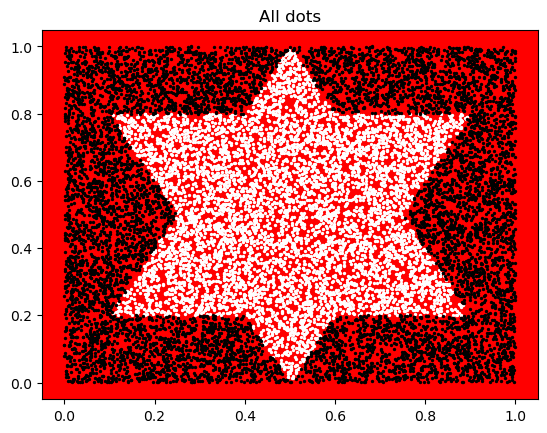

In [9]:
# Plot all points
fig, ax = plt.subplots()
ax.set_facecolor('r')
ax.scatter(x_dot[in_poly == 1], y_dot[in_poly == 1], c='w', s=2)
ax.scatter(x_dot[in_poly == 0], y_dot[in_poly == 0], c='k', s=2)
ax.set_title('All dots')


## Split Data

Split the data into training (80%), validation (10%), and test (10%) sets.

In [10]:
# Split data
idx_train = np.arange(int(0.8 * DataSize))
idx_val = np.arange(int(0.8 * DataSize), int(0.9 * DataSize))
idx_test = np.arange(int(0.9 * DataSize), DataSize)
X_train, y_train = points[idx_train], in_poly[idx_train]
X_val, y_val     = points[idx_val],   in_poly[idx_val]
X_test, y_test   = points[idx_test],  in_poly[idx_test]

## Train Logistic Regression

Train the logistic regression model and plot the training cost over epochs.

Logistic validation accuracy: 54.20%
Logistic validation accuracy: 54.20%
Logistic validation accuracy: 54.20%


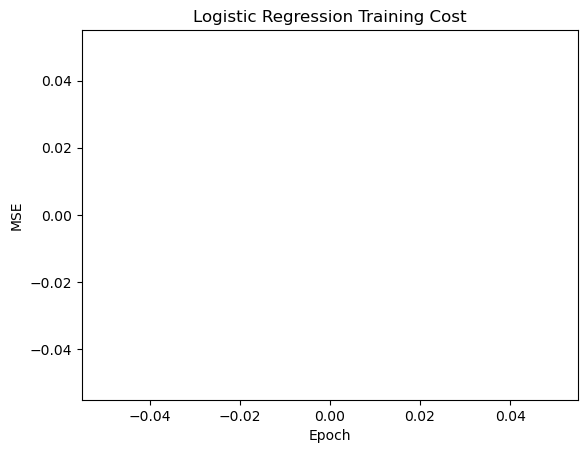

In [20]:
# Train logistic regression
log_reg = LogisticRegressionSGD(lr=0.12)
cost_log = log_reg.fit(X_train, y_train, X_val, y_val)
plt.figure()
plt.plot(cost_log)
plt.title('Logistic Regression Training Cost')
plt.xlabel('Epoch')
plt.ylabel('MSE')


## Test Logistic Regression

Evaluate the logistic regression model on the test set and visualize the predicted probabilities.

Logistic Regression Test Accuracy: 60.87%


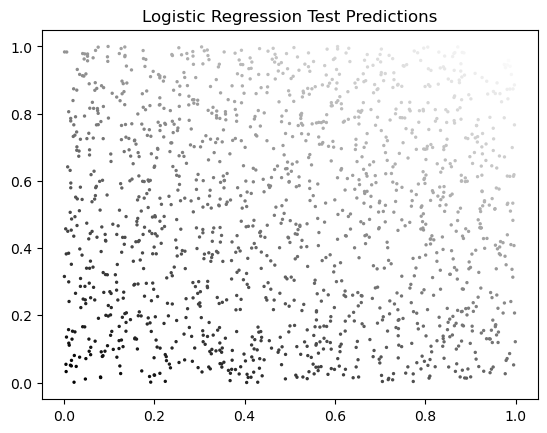

In [21]:
# Test logistic regression
y_prob = log_reg.predict_proba(X_test)
y_pred = log_reg.predict(X_test)
test_acc = np.mean(y_pred == y_test) * 100
print(f"Logistic Regression Test Accuracy: {test_acc:.2f}%")
plt.figure()
plt.scatter(X_test[:,0], X_test[:,1], c=y_prob, cmap='gray', s=2)
plt.title('Logistic Regression Test Predictions')


## Two-Layer Neural Network

This section explains the weight update process for the two-layer neural network, which uses **Stochastic Gradient Descent (SGD)** with **backpropagation** to minimize the mean squared error (MSE) loss function.

### Network Architecture
The network consists of:
- **Input layer**: Accepts input features \( x_i \) (2D points plus a bias term, so dimension is 3).
- **Hidden layer**: Contains 25 neurons, with weight matrix \( W1 \) of shape \( (25, 3) \). Each neuron computes a weighted sum followed by a sigmoid activation.
- **Output layer**: A single neuron with weight matrix \( W2 \) of shape \( (1, 26) \) (25 hidden neurons plus a bias term), producing a probability via sigmoid activation.

### Loss Function
The loss function is the squared error for a single example:
\[ L = (o_{out} - y_i)^2 \]
where \( o_{out} = \sigma(W2 \cdot h_{bias}) \) is the predicted output, \( y_i \) is the true label, and \( h_{bias} = [\sigma(W1 \cdot x_i), 1] \) is the hidden layer output with a bias term.

### Forward Pass
For each training example \( (x_i, y_i) \):
1. **Hidden layer**:
   - Compute the weighted sum: \( h_{net} = W1 \cdot x_i \).
   - Apply sigmoid activation: \( h_{out} = \sigma(h_{net}) \).
   - Append a bias term: \( h_{bias} = [h_{out}, 1] \).
2. **Output layer**:
   - Compute the weighted sum: \( o_{net} = W2 \cdot h_{bias} \).
   - Apply sigmoid activation: \( o_{out} = \sigma(o_{net}) \).

The error is calculated as:
\[ error = o_{out} - y_i \]
and the loss is stored as \( error^2 \).

### Backward Pass (Backpropagation)
The weights are updated by computing the gradients of the loss \( L \) with respect to \( W2 \) and \( W1 \), then applying SGD.

#### Gradient for \( W2 \) (Output Layer)
The gradient of the loss with respect to \( W2 \) is computed using the chain rule:
\[ \frac{\partial L}{\partial W2} = \frac{\partial L}{\partial o_{out}} \cdot \frac{\partial o_{out}}{\partial o_{net}} \cdot \frac{\partial o_{net}}{\partial W2} \]
- **Step 1**: Derivative of the loss with respect to the output:
  \[ \frac{\partial L}{\partial o_{out}} = 2 (o_{out} - y_i) \approx error \]
  The factor of 2 is absorbed into the learning rate in the implementation.
- **Step 2**: Derivative of the sigmoid output with respect to its input:
  \[ \frac{\partial o_{out}}{\partial o_{net}} = \sigma'(o_{out}) = o_{out} \cdot (1 - o_{out}) \]
  This is computed as `sigmoid_derivative(o_out)`.
- **Step 3**: Derivative of the output layer's weighted sum with respect to \( W2 \):
  \[ \frac{\partial o_{net}}{\partial W2} = h_{bias} \]
Thus, the gradient is:
\[ \frac{\partial L}{\partial W2} = (o_{out} - y_i) \cdot \sigma'(o_{out}) \cdot h_{bias} \]
In the code:
```python
delta2 = error * sigmoid_derivative(o_out)
grad_W2 = delta2 * h_bias
```
where \( delta2 = (o_{out} - y_i) \cdot \sigma'(o_{out}) \).

#### Gradient for \( W1 \) (Hidden Layer)
The gradient for \( W1 \) requires propagating the error back through the network:
\[ \frac{\partial L}{\partial W1} = \frac{\partial L}{\partial h_{out}} \cdot \frac{\partial h_{out}}{\partial h_{net}} \cdot \frac{\partial h_{net}}{\partial W1} \]
- **Step 1**: Derivative of the loss with respect to the hidden layer output:
  \[ \frac{\partial L}{\partial h_{out}} = \frac{\partial L}{\partial o_{net}} \cdot \frac{\partial o_{net}}{\partial h_{out}} \]
  - From the output layer: \( \frac{\partial L}{\partial o_{net}} = (o_{out} - y_i) \cdot \sigma'(o_{out}) = delta2 \).
  - The derivative \( \frac{\partial o_{net}}{\partial h_{out}} = W2[:, :-1] \) (excluding the bias weight).
  - Thus:
    \[ \frac{\partial L}{\partial h_{out}} = delta2 \cdot W2[:, :-1] \]
- **Step 2**: Derivative of the hidden layer output with respect to its input:
  \[ \frac{\partial h_{out}}{\partial h_{net}} = \sigma'(h_{out}) \]
  This is computed as `sigmoid_derivative(h_out)`.
- **Step 3**: Derivative of the hidden layer's weighted sum with respect to \( W1 \):
  \[ \frac{\partial h_{net}}{\partial W1} = x_i \]
Thus, the gradient is:
\[ \frac{\partial L}{\partial W1} = [ (W2[:, :-1]^T \cdot delta2) \cdot \sigma'(h_{out}) ] \otimes x_i \]
where \( \otimes \) denotes the outer product. In the code:
```python
delta1 = (self.W2[:, :-1].T.dot(delta2)) * sigmoid_derivative(h_out)
grad_W1 = np.outer(delta1, x_i)
```
where \( delta1 = (W2[:, :-1]^T \cdot delta2) \cdot \sigma'(h_{out}) \).

#### Weight Update
The weights are updated using SGD with learning rate \( \eta = 0.12 \):
\[ W2 \gets W2 - \eta \cdot grad_{W2} \]
\[ W1 \gets W1 - \eta \cdot grad_{W1} \]
In the code:
```python
self.W2 -= self.lr * grad_W2
self.W1 -= self.lr * grad_W1
```

### Why It Works
- **Backpropagation**: Efficiently computes gradients for all weights by propagating the error backward, enabling the network to learn complex patterns.
- **SGD**: Updates weights per example, making training faster and suitable for large datasets.
- **Sigmoid Activation**: Maps outputs to [0,1], ideal for binary classification, with a derivative that facilitates gradient computation.
- **Learning Rate**: The value \( \eta = 0.12 \) balances the speed and stability of learning.

This process repeats for each training example in each epoch, iteratively minimizing the loss and improving the model's predictions.

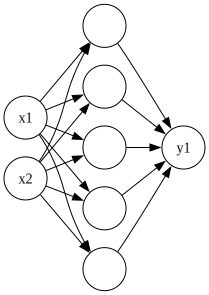

In [10]:
from graphviz import Digraph

def draw_neural_net(layer_sizes):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR')
    for l, size in enumerate(layer_sizes):
        for n in range(size):
            node_id = f"L{l}_N{n}"
            label = "" if l != 0 and l != len(layer_sizes)-1 else (
                f"x{n+1}" if l == 0 else f"y{n+1}"
            )
            dot.node(node_id, label=label, shape="circle", width="0.6", fixedsize="true")
    for l in range(len(layer_sizes) - 1):
        for src in range(layer_sizes[l]):
            for dst in range(layer_sizes[l + 1]):
                dot.edge(f"L{l}_N{src}", f"L{l+1}_N{dst}")
    return dot

# פשוט להריץ את זה בתא:
draw_neural_net([2, 5, 1])


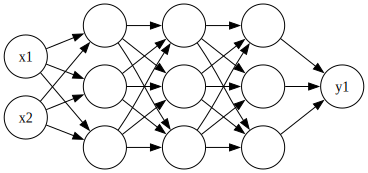

In [11]:
draw_neural_net([2, 3,3,3, 1])

## Train Two-Layer Neural Network

Train the two-layer neural network and plot the training cost over epochs.

Two-layer NN validation accuracy: 98.20%


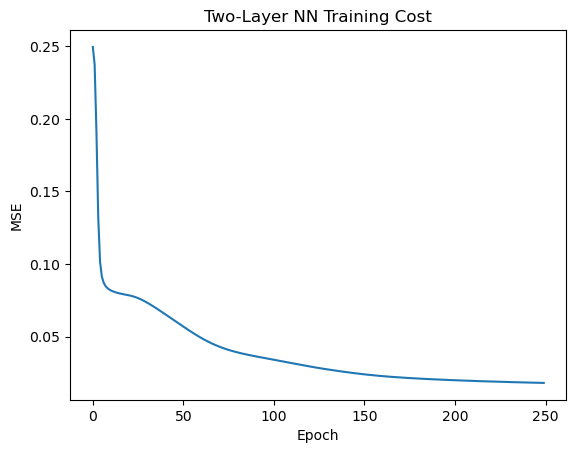

In [22]:
# Train two-layer neural network
nn = TwoLayerNN(input_dim=2, hidden_dim=25, lr=0.12)
cost_nn = nn.fit(X_train, y_train, X_val, y_val)
plt.figure()
plt.plot(cost_nn)
plt.title('Two-Layer NN Training Cost')
plt.xlabel('Epoch')
plt.ylabel('MSE')


## Test Two-Layer Neural Network

Evaluate the neural network on the test set and visualize the predicted probabilities and rounded predictions.

Two-Layer NN Test Accuracy: 97.27%


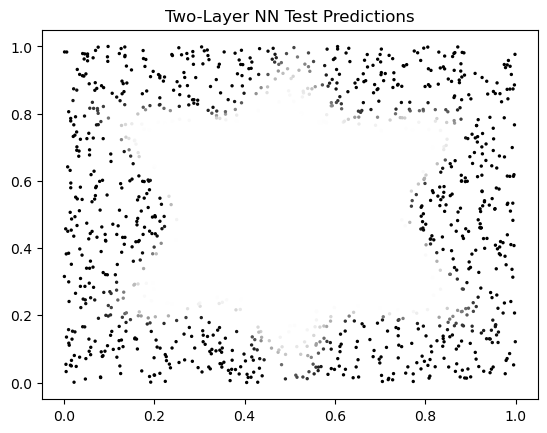

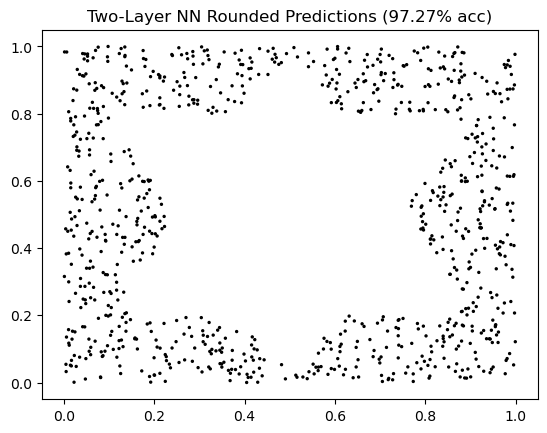

In [23]:
# Test two-layer NN and visualize
y_nn_prob = nn.predict_proba(X_test)
y_nn_pred = nn.predict(X_test)
test_acc_nn = np.mean(y_nn_pred == y_test) * 100
print(f"Two-Layer NN Test Accuracy: {test_acc_nn:.2f}%")
plt.figure()
plt.scatter(X_test[:,0], X_test[:,1], c=y_nn_prob, cmap='gray', s=2)
plt.title('Two-Layer NN Test Predictions')
plt.savefig('nn_predictions.png')


# Rounded predictions
plt.figure()
plt.scatter(X_test[:,0], X_test[:,1], c=y_nn_pred, cmap='gray', s=2)
plt.title(f'Two-Layer NN Rounded Predictions ({test_acc_nn:.2f}% acc)')


## Visualize Hidden Layer Activations

Visualize the activations of each neuron in the hidden layer of the neural network.

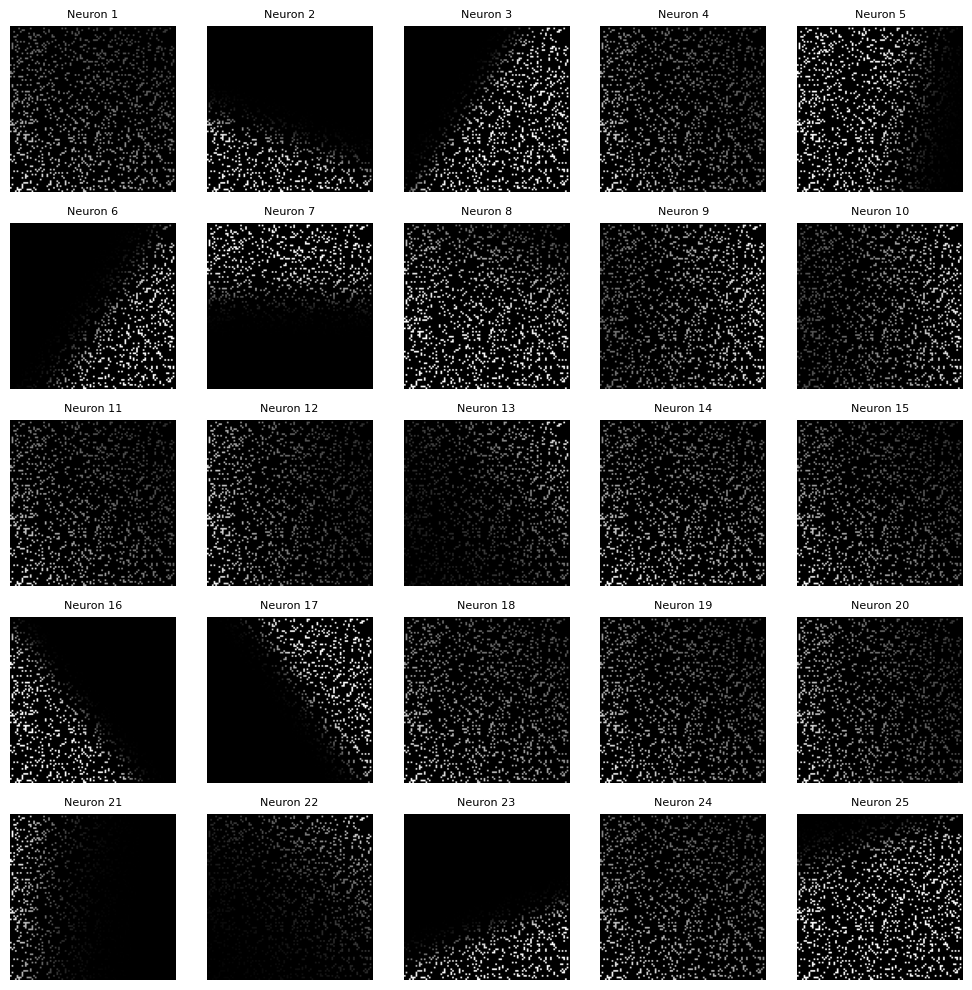

In [24]:
# Visualize all hidden activations in subplots
X_test_bias = np.hstack([X_test, np.ones((len(X_test), 1))])
h_net_all = X_test_bias.dot(nn.W1.T)
h_out_all = sigmoid(h_net_all)

n_neurons = nn.hidden_dim
n_cols = int(math.ceil(math.sqrt(n_neurons)))
n_rows = int(math.ceil(n_neurons / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
axes = axes.flatten()

grid_size = 100
xi = np.clip((X_test[:,0] * (grid_size-1)).astype(int), 0, grid_size-1)
yi = np.clip((X_test[:,1] * (grid_size-1)).astype(int), 0, grid_size-1)

for idx in range(n_neurons):
    activation_map = np.zeros((grid_size, grid_size))
    activation_map[xi, yi] = h_out_all[:, idx]
    ax = axes[idx]
    ax.imshow(activation_map, origin='lower', cmap='gray', extent=[0,1,0,1])
    ax.set_title(f'Neuron {idx+1}', fontsize=8)
    ax.axis('off')

for j in range(n_neurons, len(axes)):
    axes[j].axis('off')

plt.tight_layout()


# Two-Layer Neural Network on MPS (Apple Silicon) with PyTorch
### פתרון מודל נוירונים דו-שכבתי על נתונים מקוריים מהמחברת שלך
---

In [18]:
# ייבוא ספריות והגדרת device (MPS ל-Apple Silicon, אחרת CPU)
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Running on Apple GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on Apple GPU (MPS)


### כאן לא יוצרים דאטה! רק מניחים שהמשתנים הבאים כבר קיימים במחברת:
- X_train, X_test, y_train, y_test (כמו ב-NumPy)

In [19]:
# ודא שמגדירים נכון את הנתונים הקיימים שלך לפני קטע זה!
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).reshape(-1,1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).reshape(-1,1).to(device)

### הגדרת רשת נוירונים דו-שכבתית

In [20]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = TwoLayerNN(input_dim=X_train.shape[1]).to(device)

### הגדרת פונקציית אובדן ואופטימייזר

In [21]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### אימון המודל ובדיקת דיוק על סט הבדיקה

In [22]:
epochs = 600
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = loss_fn(y_pred, y_train_t)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0 or epoch == 0:
        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test_t)
            test_pred_label = (y_test_pred > 0.5).float()
            acc = (test_pred_label == y_test_t).float().mean().item()
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Test Accuracy: {acc*100:.2f}%")

Epoch 1, Loss: 0.7162, Test Accuracy: 45.20%
Epoch 100, Loss: 0.5552, Test Accuracy: 77.20%
Epoch 200, Loss: 0.3354, Test Accuracy: 90.07%
Epoch 300, Loss: 0.2362, Test Accuracy: 91.27%
Epoch 400, Loss: 0.2042, Test Accuracy: 91.60%
Epoch 500, Loss: 0.1905, Test Accuracy: 91.47%
Epoch 600, Loss: 0.1840, Test Accuracy: 91.47%


### גרף גבול החלטה (Decision Boundary) + תצוגת הדאטה


Final Test Accuracy: 91.47%


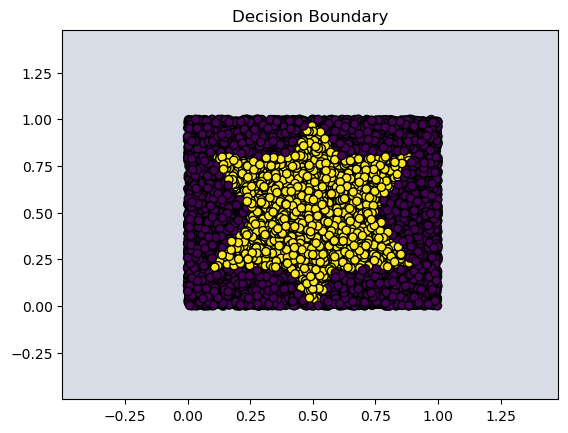

In [23]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_t)
    test_pred_label = (y_test_pred > 0.5).float()
    acc = (test_pred_label == y_test_t).float().mean().item()
print(f"\nFinal Test Accuracy: {acc*100:.2f}%")

def plot_decision_boundary(model, X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    X_grid_t = torch.tensor(X_grid, dtype=torch.float32).to(device)
    with torch.no_grad():
        Z = model(X_grid_t)
    Z = Z.cpu().numpy().reshape(xx.shape)
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.2)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k')
    plt.title("Decision Boundary")
    plt.show()

plot_decision_boundary(model, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]))